# **RevCheck - Final Project**

## **Introduction**

The RevCheck project started because forecasting models have been widely applied in businesses.1 Using advanced LSTM technology, RevCheck aims to understand the patterns in sales data better, helping businesses make smarter decisions.

By combining data science and business know-how, RevCheck wants to change how companies forecast revenue, giving them the tools to grow steadily in today's fast-changing markets.

## **Problem Statement**

Background:

Our company operates a chain of bike shops across different locations. Accurate revenue forecasting is essential for financial planning, budget allocation, and overall business strategy. We have historical data on revenue generated by each shop, including factors such as date, location, bike sales, accessories, and services.

Objective:

The objective is to develop a predictive model that can accurately forecast future revenue for each bike shop based on historical data.

Data:

Historical data on revenue generated by each bike shop, including dates, locations, and revenue components (e.g., bike sales, accessories, services).

Constraints:

The model should be computationally efficient for real-time predictions.
The prediction horizon should be reasonable, from weeks.

Success Criteria:

The success criteria for the model will be a mean absolute percentage error (MAPE) on the test dataset below a certain threshold, indicating accurate predictions of future revenue for each bike shop.

## **Import libraries**

In [132]:
# Library for manipulation data
import numpy as np
import pandas as pd

# Library for visualization
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams

# Library for scaling
from sklearn.preprocessing import MinMaxScaler
# Library for modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## **Load Data**

Also, change data type that needs to change

In [133]:
data = pd.read_csv('/Users/dewaalmatin/Documents/Hacktiv8/airflow_final_project/dags/sales_clean.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112036 entries, 0 to 112035
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              112036 non-null  datetime64[ns]
 1   Customer_Age      112036 non-null  int64         
 2   Age_Group         112036 non-null  object        
 3   Customer_Gender   112036 non-null  object        
 4   Country           112036 non-null  object        
 5   State             112036 non-null  object        
 6   Product_Category  112036 non-null  object        
 7   Sub_Category      112036 non-null  object        
 8   Product           112036 non-null  object        
 9   Order_Quantity    112036 non-null  int64         
 10  Unit_Cost         112036 non-null  int64         
 11  Unit_Price        112036 non-null  int64         
 12  Profit            112036 non-null  int64         
 13  Cost              112036 non-null  int64         
 14  Reve

For this project, i used the data from ``2015-07-01`` untill ``2016-07-01``

In [134]:
data = data.loc[(data['Date'] >= '2015-07-01') & (data['Date'] < '2016-07-01')]

Change columns name to lowercase

In [135]:
# Lower case column names
data.columns = map(str.lower, data.columns)
data.columns

Index(['date', 'customer_age', 'age_group', 'customer_gender', 'country',
       'state', 'product_category', 'sub_category', 'product',
       'order_quantity', 'unit_cost', 'unit_price', 'profit', 'cost',
       'revenue'],
      dtype='object')

## Separate dataframe of each category

**Agregating Revenue by Date**

In [136]:
rev= data.groupby('date')['revenue'].sum().reset_index()
rev

,date,revenue
0,2015-07-01,52857
1,2015-07-02,59586
2,2015-07-03,50141
3,2015-07-04,80482
4,2015-07-05,39656
...,...,...
360,2016-06-26,120422
361,2016-06-27,119620
362,2016-06-28,133138
363,2016-06-29,103095


By doing this, the 'date' column becomes the new index of the DataFrame, allowing for easier access and manipulation of data based on dates.

In [137]:
#Set index 
rev = rev.set_index('date')

## **Visualization**

Next step is want to explore about this dataset so visualizing the revenue data

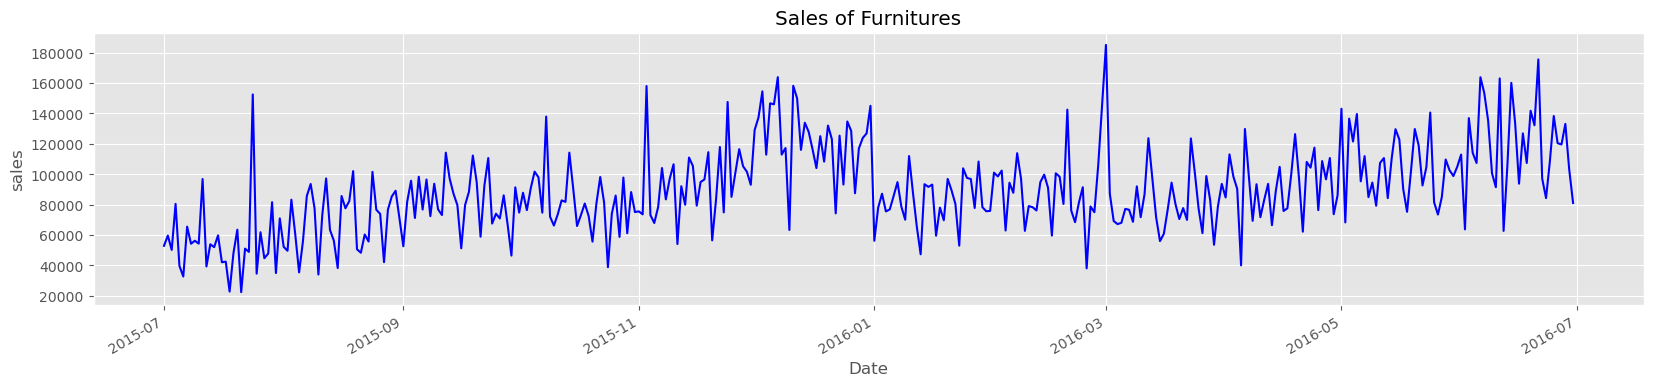

In [293]:
# Plot the 'revenue' column from the DataFrame 'rev'
ax= rev['revenue'].plot(color='blue',figsize=(20,4))
# Set labels for x and y axes
ax.set_xlabel("Date")
ax.set_ylabel('revenue')
# Set title for the plot
ax.set_title("Sales of Bike")
plt.show()

To compute the average daily sales value and set the start of the week as the index, we first resample the sales data to the weekly level and then calculate the sum of sales for each week. This allows us to obtain a series representing the total weekly revenue. The resulting DataFrame, `df`, contains the weekly sum of sales, with the start of each week set as the index.

In [255]:
# Using averages daily sales value - set start of the week as index
df = rev['revenue'].resample('W').sum()

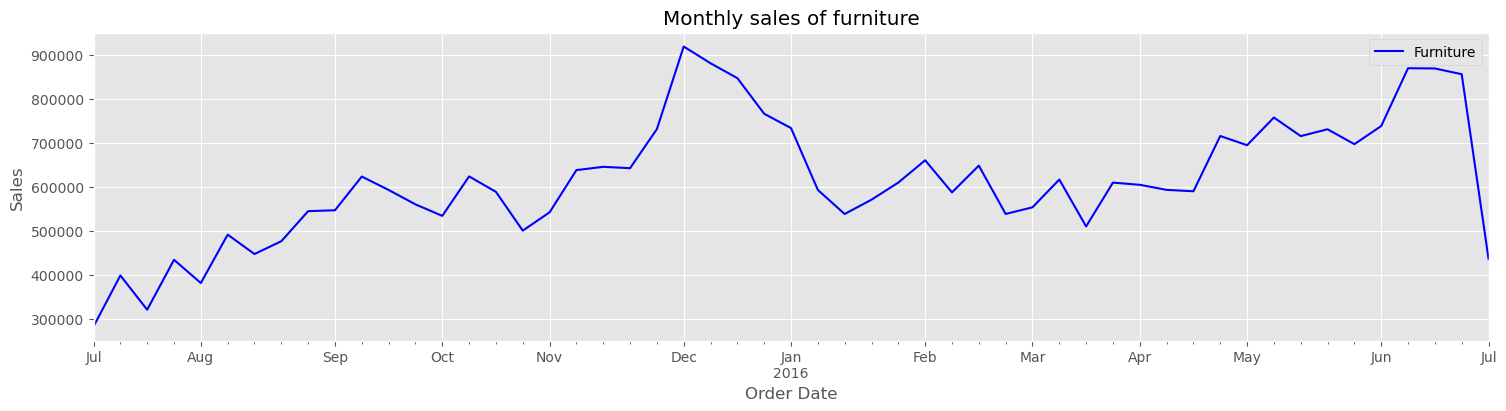

In [257]:
df.plot(figsize=(18, 4),color='blue',label = 'Bike')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Revenue')
plt.title("Monthly sales of bike")
plt.legend()
plt.show()

The plot above illustrates the monthly sales of furniture products. The blue line represents the sales trend over time. Each point on the plot corresponds to the total sales value for a specific month, with the x-axis denoting the order date and the y-axis representing the sales amount. Additionally, a legend is included to distinguish between different product categories, although only furniture sales are displayed in this plot.

## Measure of prediction accuracy

The `performance` function calculates the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) between the true and predicted values. The result is returned as a dictionary containing the computed performance metrics rounded to two decimal places.

The `performance2` function also calculates the MSE, RMSE, and MAPE, but it directly prints the results instead of returning them as a dictionary. The output includes the MSE, RMSE, and MAPE values, each rounded to two decimal places.

In [142]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## **LSTM**

The code converts a pandas Series containing the dataset into a NumPy array and reshapes it to have a single feature (column). It then defines the proportion of data to allocate for training (78% in this case) and calculates the index that separates the training and testing sets based on this proportion. Finally, it splits the dataset into training and testing sets and prints the sizes of the split datasets.

In [265]:
# Convert the pandas Series into a NumPy array
data_array = np.array(df).reshape(-1,1)

# Define the proportion of data to allocate for training
train_size = 0.78  # 80% of the data for training, 20% for testing

# Calculate the index that separates the training and testing sets
train_index = int(len(data_array) * train_size)

# Split the data into training and testing sets
train = data_array[:train_index]
test = data_array[train_index:]

# Print the sizes of the split datasets
print("Training data size:", len(train))
print("Testing data size:", len(test))

Training data size: 41
Testing data size: 12


This code, scales the training and testing data to the range [-1, 1] using the MinMaxScaler from scikit-learn. It first fits the scaler to the training data, then transforms both the training and testing data accordingly.

In [266]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

The variable `n_input` is set to 12, representing the number of lag observations to use as input for each sample. The dataset is univariate, meaning it contains only one feature. The `TimeseriesGenerator` class is then used to automatically transform the univariate time series dataset into a supervised learning problem. It generates batches of temporal data for training using the specified `length` (number of lag observations) and `batch_size`.

In [267]:
n_input = 12
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

## **Bidirectional LSTM**

A bidirectional LSTM model is defined using Keras Sequential API. The model consists of a Bidirectional LSTM layer with 50 units and 'relu' activation function, followed by a Dense output layer with 1 unit. The model is compiled using the Adam optimizer and mean absolute percentage error (MAPE) loss function.

In [280]:
# define model
warnings.filterwarnings("ignore") # Ignore any warnings that may occur during model training or compilation
model_bi = Sequential() # Create a sequential model, which is a linear stack of layers
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1))) # Add a Bidirectional LSTM layer with 50 units and 'relu' activation function, taking input shape (12, 1)
model_bi.add(Dense(1))  # Add a Dense output layer with 1 unit
model_bi.compile(optimizer='adam', loss='mape') # Compile the model using the Adam optimizer and mean absolute percentage error (MAPE) loss function

In [281]:
# Fit the model
model_bi.fit_generator(generator,epochs=800)

Epoch 1/800
3/3 [==============================] - 3s 7ms/step - loss: 82.2986
Epoch 2/800
3/3 [==============================] - 0s 7ms/step - loss: 74.0849
Epoch 3/800
3/3 [==============================] - 0s 8ms/step - loss: 65.3838
Epoch 4/800
3/3 [==============================] - 0s 8ms/step - loss: 55.1357
Epoch 5/800
3/3 [==============================] - 0s 8ms/step - loss: 43.0300
Epoch 6/800
3/3 [==============================] - 0s 9ms/step - loss: 32.2902
Epoch 7/800
3/3 [==============================] - 0s 7ms/step - loss: 26.3094
Epoch 8/800
3/3 [==============================] - 0s 8ms/step - loss: 25.2841
Epoch 9/800
3/3 [==============================] - 0s 8ms/step - loss: 26.7253
Epoch 10/800
3/3 [==============================] - 0s 7ms/step - loss: 26.4805
Epoch 11/800
3/3 [==============================] - 0s 8ms/step - loss: 24.5228
Epoch 12/800
3/3 [==============================] - 0s 34ms/step - loss: 22.8522
Epoch 13/800
3/3 [==============================

This code snippet generates predictions using a bidirectional LSTM model. It initializes an empty list `pred_list_b` to store the predictions. Then, it defines the input size `n_input` as 12 and reshapes the last 12 elements of the training data into a batch. Next, it iterates through each time step in the input batch, predicting the next value using the bidirectional LSTM model `model_bi`. The predicted value is appended to `pred_list_b`, and the batch is updated by removing the first element and adding the predicted value. Finally, the predicted values are inverse transformed using the scaler and stored in a DataFrame `df_predict_bi`.

In [282]:
pred_list_b = [] # Initialize an empty list to store the predicted values
n_input = 12 # Define the number of input time steps

batch = train[-n_input:].reshape((1, n_input, n_features))  # Prepare the initial input batch for prediction, reshaping it to match the input shape of the model

for i in range(n_input):  
    pred_list_b.append(model_bi.predict(batch)[0]) # Predict the next value using the model and append it to the prediction list
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1) # Update the input batch by removing the first element and adding the predicted value at the end

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])  # Convert the predicted values back to the original scale using the scaler & # Create a DataFrame to store the predictions with appropriate index and column names

1/1 [==============================] - 0s 26ms/step


This generates a line plot comparing the observed furniture sales (`Observed`) with the predictions made by the bidirectional LSTM model (`Bidirectional LSTM Prediction`). The plot displays the sales data over time, with the x-axis representing the date and the y-axis representing the furniture sales. The observed sales data is plotted in blue (`#2574BF`), while the predictions made by the bidirectional LSTM model are overlaid on the same plot

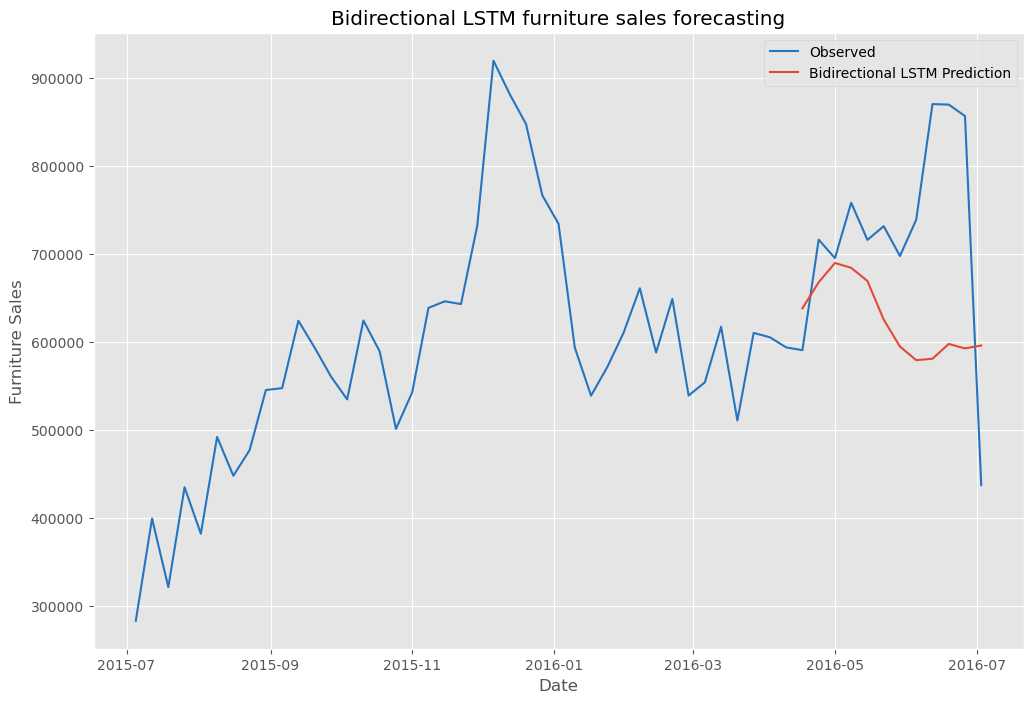

In [284]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df_predict_bi.index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM bike sales forecasting')
plt.xlabel('Date')
plt.ylabel('Bike Sales')
plt.legend()
plt.show()

In [283]:
# Showing the dataframe 
df_predict_bi

,Prediction
date,
2016-04-17,638047.679536
2016-04-24,667670.511117
2016-05-01,689659.262782
2016-05-08,684145.910379
2016-05-15,669142.419101
2016-05-22,625261.845742
2016-05-29,594557.996309
2016-06-05,579085.060999
2016-06-12,580699.402505


The performance metrics for the Bidirectional LSTM model are as follows:

- MSE (Mean Squared Error): {MSE value}
- RMSE (Root Mean Squared Error): {RMSE value}
- MAPE (Mean Absolute Percentage Error): {MAPE value}

The output provides performance metrics for the Bidirectional LSTM model, indicating its effectiveness in forecasting bike sales. The metrics include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). These metrics help evaluate the accuracy and reliability of the model's predictions, with lower values indicating better performance.

In [285]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm

{'MSE': 26068944535.5, 'RMSE': 161458.8, 'MAPE': 17.88}

In [289]:
def generate_date_list(start_date):
    """
    Generate a list of 12 consecutive dates starting from the given start date in the specified format.
    
    Parameters:
        start_date (str): Start date in 'YYYY-MM-DD' format.
    
    Returns:
        pd.DatetimeIndex: DatetimeIndex containing 12 consecutive dates in the specified format.
    """
    # Convert start date to datetime object
    start_date = pd.to_datetime(start_date)
    
    # Generate 12 consecutive dates starting from the start date
    date_list = pd.date_range(start=start_date, periods=12, freq='W-SUN')
    
    return date_list

# Example usage:
start_date = '2016-07-03'
date_list = generate_date_list(start_date)

# Print the generated date list
print(date_list)

DatetimeIndex(['2016-07-03', '2016-07-10', '2016-07-17', '2016-07-24',
               '2016-07-31', '2016-08-07', '2016-08-14', '2016-08-21',
               '2016-08-28', '2016-09-04', '2016-09-11', '2016-09-18'],
              dtype='datetime64[ns]', freq='W-SUN')


In [195]:
last_week = df[-1:].index
pred_start = last_week.strftime('%Y-%m-%d').tolist()
pred_start[0]

'2016-07-03'

An empty list to store predictions (pred_list_b), extracts the last week's date as a string (pred_start), reshapes the test data for prediction (batch), iterates over each time step to generate predictions using the Bidirectional LSTM model, and stores the predicted values in a DataFrame indexed by dates.

In [290]:
pred_list_b = []
last_week = df[-1:].index
pred_start = last_week.strftime('%Y-%m-%d').tolist()

batch = test.reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=generate_date_list(pred_start[0]), columns=['Prediction'])

1/1 [==============================] - 0s 28ms/step


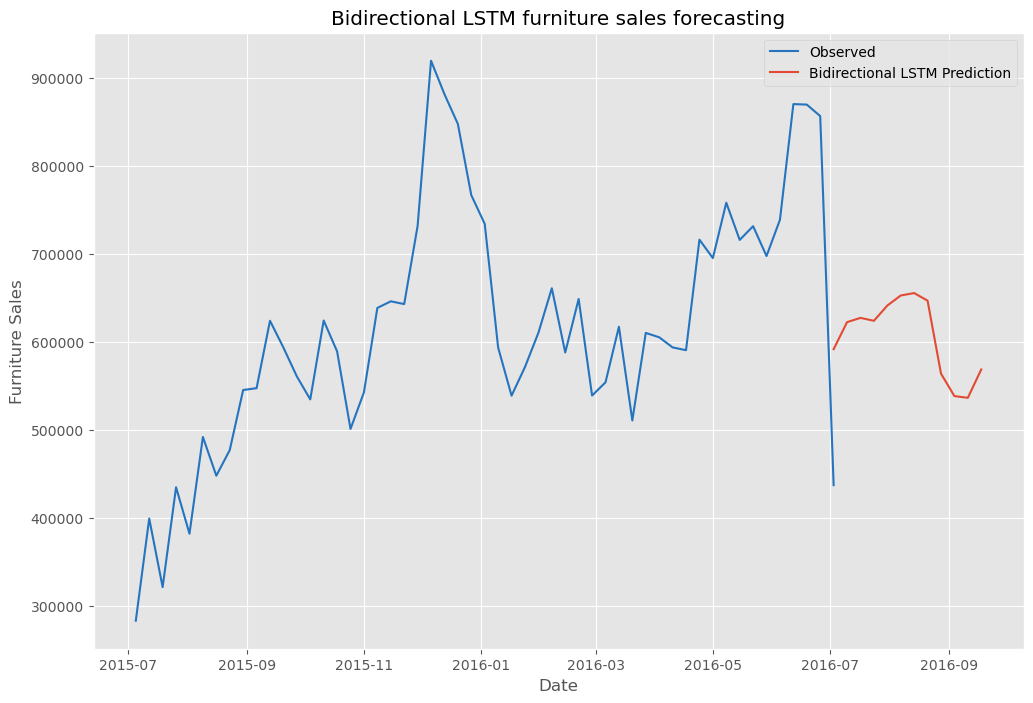

In [291]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df_predict_bi.index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM bike sales forecasting')
plt.xlabel('Date')
plt.ylabel('Bike Sales')
plt.legend()
plt.show()

## **Saving Model**

In [292]:
model_bi.save('my_model.keras')